# ECE421 Assignment 3: Unsupervised Learning and Probabilistic Models
---
Name: Prerak Chaudhari

Student Number: 1005114760

Date: April 9, 2021

In [177]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

2.4.1


In [178]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [179]:
def reduce_logsumexp(input_tensor, reduction_indices=1, keep_dims=False):
  """Computes the sum of elements across dimensions of a tensor in log domain.

     It uses a similar API to tf.reduce_sum.

  Args:
    input_tensor: The tensor to reduce. Should have numeric type.
    reduction_indices: The dimensions to reduce. 
    keep_dims: If true, retains reduced dimensions with length 1.
  Returns:
    The reduced tensor.
  """
  max_input_tensor1 = tf.reduce_max(
      input_tensor, reduction_indices, keepdims=keep_dims)
  max_input_tensor2 = max_input_tensor1
  if not keep_dims:
    max_input_tensor2 = tf.expand_dims(max_input_tensor2, reduction_indices)
  return tf.math.log(
      tf.reduce_sum(
          tf.exp(input_tensor - max_input_tensor2),
          reduction_indices,
          keepdims=keep_dims)) + max_input_tensor1

In [180]:
def logsoftmax(input_tensor):
  """Computes normal softmax nonlinearity in log domain.

     It can be used to normalize log probability.
     The softmax is always computed along the second dimension of the input Tensor.     

  Args:
    input_tensor: Unnormalized log probability.
  Returns:
    normalized log probability.
  """
  return input_tensor - reduce_logsumexp(input_tensor, reduction_indices=0, keep_dims=True)

In [181]:
path_data100D = '/content/drive/MyDrive/ece421/assignments/a3/data100D.npy'
path_data2D = '/content/drive/MyDrive/ece421/assignments/a3/data2D.npy'

In [182]:
def loadData(path, is_valid=True):
    # Loading data
    data = np.load(path)
    val_data = None
    [num_pts, dim] = np.shape(data)

    # For Validation set
    if is_valid:
        valid_batch = int(num_pts / 3.0)
        np.random.seed(45689)
        rnd_idx = np.arange(num_pts)
        np.random.shuffle(rnd_idx)
        val_data = data[rnd_idx[:valid_batch]]
        data = data[rnd_idx[valid_batch:]]

    return data, val_data

# Part 1: K-means [9 points]

## Part 1.1:  Learning K-means

### Part 1.1.1

In [183]:
# Distance function for K-means
def distanceFunc(X, MU):
    # Inputs
    # X: is an NxD matrix (N observations and D dimensions)
    # MU: is an KxD matrix (K means and D dimensions)
    # Outputs
    # pair_dist: is the squared pairwise distance matrix (NxK)
    
    new_X = np.expand_dims(X, 1)
    new_MU = tf.expand_dims(MU, 0)

    pair_dist = tf.reduce_sum(tf.square(new_X - new_MU), axis=2)

    return pair_dist

In [184]:
def loss_MU(X, MU):
    pair_dist = distanceFunc(X, MU)
    loss_mu = tf.reduce_sum(tf.reduce_min(pair_dist, axis=1))

    return loss_mu/pair_dist.shape[0]

In [185]:
def plot_kmeans (train_loss, val_loss, data, MU, plot_val):
    n = len(train_loss)

    fig = plt.figure(figsize=(20,10))
    plt.title("K-means Loss Plot over Epochs", fontsize=20)
    plt.plot(range(1,1+n), train_loss, label="Train")
    if plot_val:
        plt.plot(range(1,1+n), val_loss, label="Validation")
    plt.xlabel("Epoch", fontsize=20)
    plt.ylabel("Loss", fontsize=20)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    print("Final Training Loss: {}".format(train_loss[-1]))
    if plot_val:
        print("Final Validation Loss: {}".format(val_loss[-1]))

    fig = plt.figure(figsize=(20,10))
    plt.title("K-means Cluster Scatter Plot for K = {}".format(MU.shape[0]), fontsize=20)
    pair_dist = distanceFunc(data, MU)
    clusters = np.argmin(pair_dist, axis=1)
    N = clusters.shape[0]
    K = MU.shape[0]
    percents = [np.sum(np.equal(i, clusters)) * 100.0 / N for i in range(K)]
    scatter = plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap=ListedColormap(cm.get_cmap("Set3").colors[:K]),
                marker="o")
    plt.scatter(MU[:, 0], MU[:, 1], c="k", marker="*")
    plt.xlabel("X", fontsize=20)
    plt.ylabel("Y", fontsize=20)
    plt.legend(handles=scatter.legend_elements()[0], labels=[str(round(p, 2))+"%" for p in percents], loc="best")
    plt.grid(True)
    if plot_val:
        caption = "The final validation loss is {}".format(val_loss[-1])
        fig.text(0.5, 0.01, caption, ha='center', fontsize=20)
    plt.show()

In [186]:
def train_kmeans (K, data_path, epochs, train_val):
    train_data, val_data = loadData(data_path, train_val)
    train_loss, val_loss = [], []

    [num_pts, dim] = np.shape(train_data)

    MU = tf.Variable(tf.random.truncated_normal([K, dim], seed=45689), trainable=True)
    
    optim = tf.keras.optimizers.Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.99, epsilon=1e-5)
    loss_fn = lambda: loss_MU(train_data, MU)

    for e in range(epochs):
        train_l = loss_MU(train_data, MU).numpy()
        train_loss.append(train_l)

        if train_val:
            val_l = loss_MU(val_data, MU).numpy()
            val_loss.append(val_l)

        optim.minimize(loss_fn, MU)

    plot_kmeans(train_loss, val_loss, train_data, MU, train_val)

    ret = None

    if train_val:
        ret = val_loss[-1]

    return ret

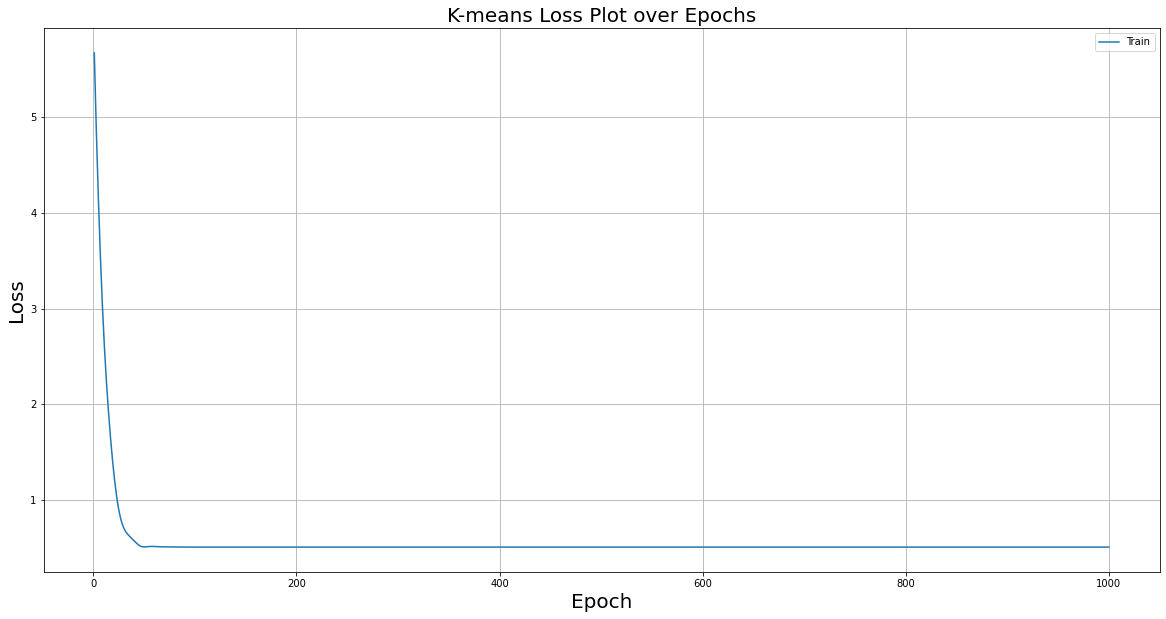

Final Training Loss: 0.5111271739006042


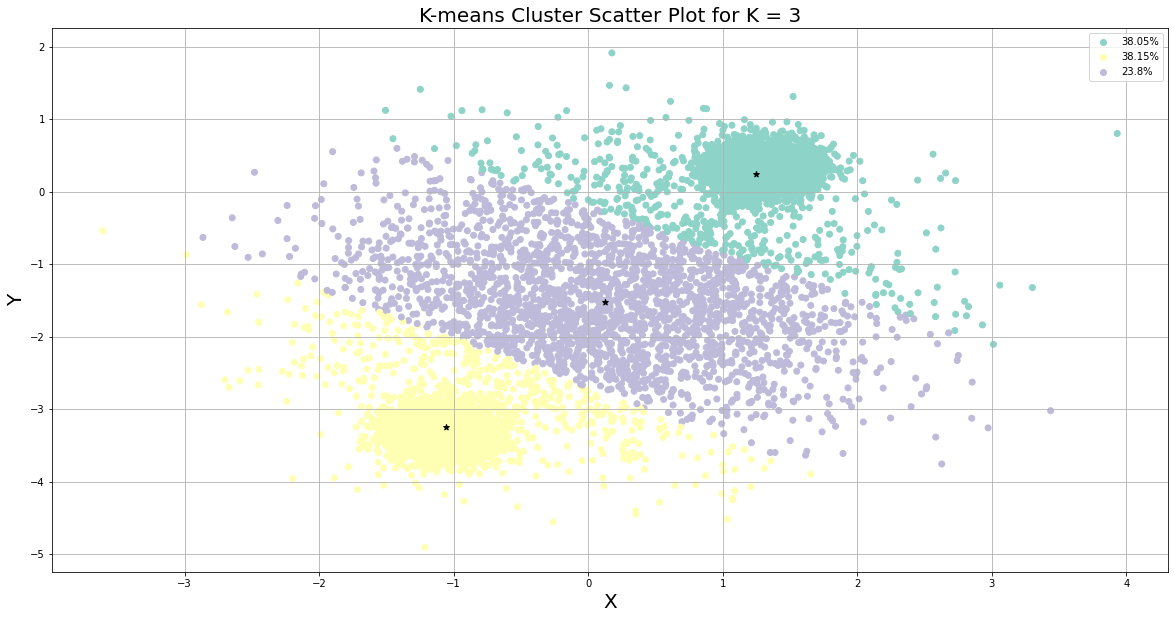

In [187]:
train_kmeans(3, path_data2D, 1000, False)

### Part 1.1.2

K = 1:


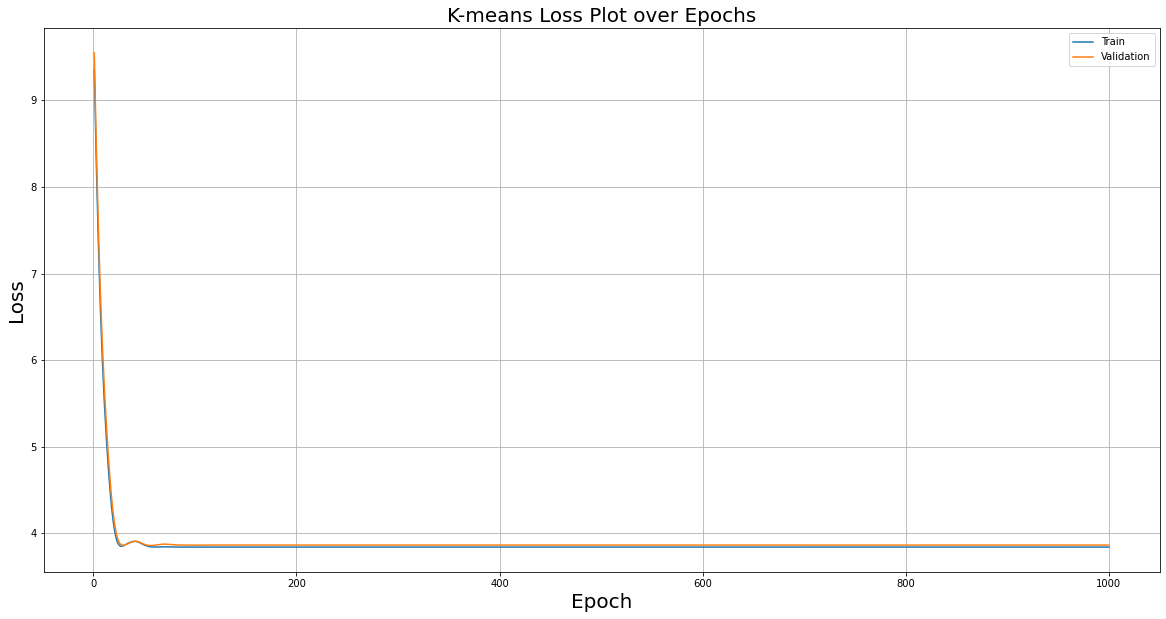

Final Training Loss: 3.8381595611572266
Final Validation Loss: 3.861290693283081


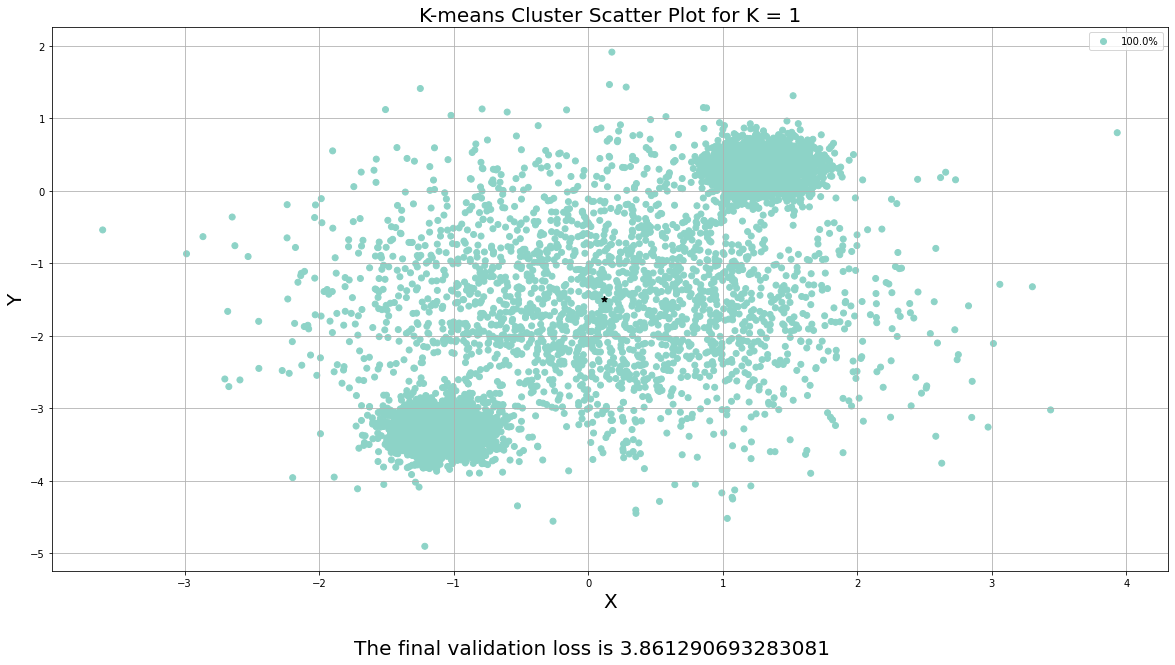




K = 2:


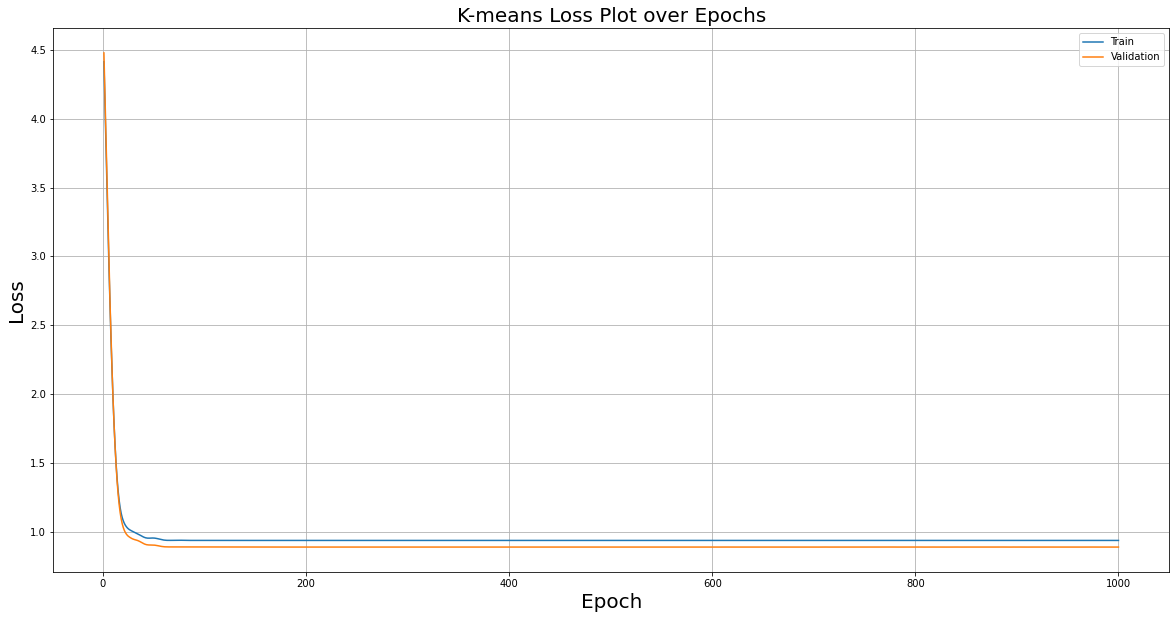

Final Training Loss: 0.9364616870880127
Final Validation Loss: 0.8882156610488892


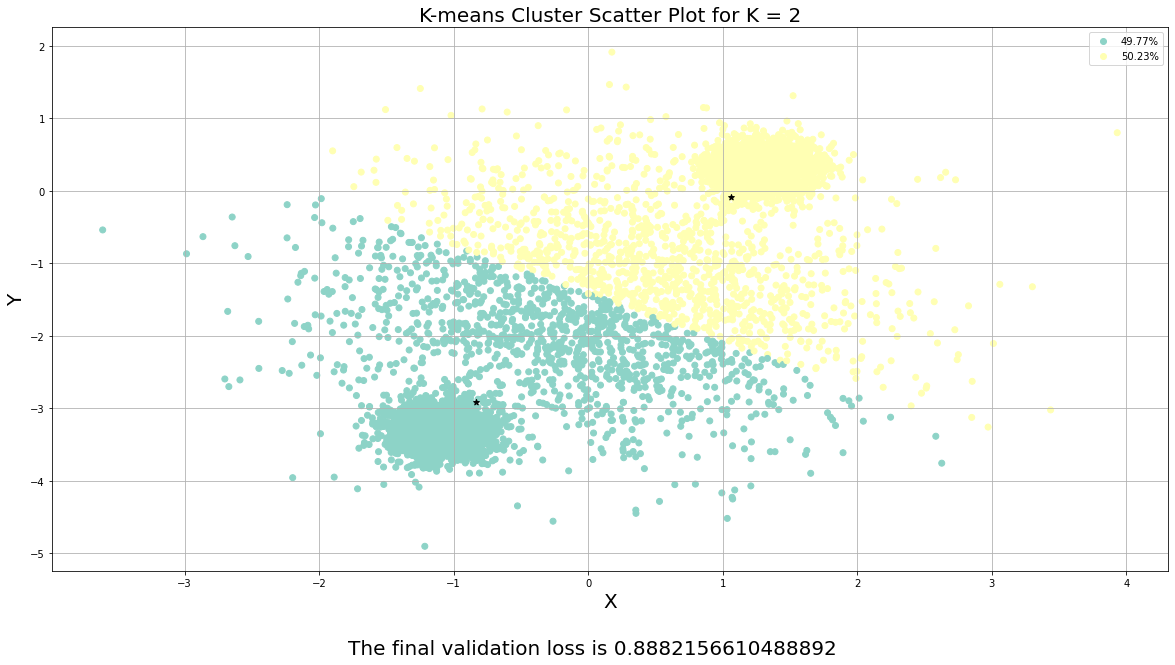




K = 3:


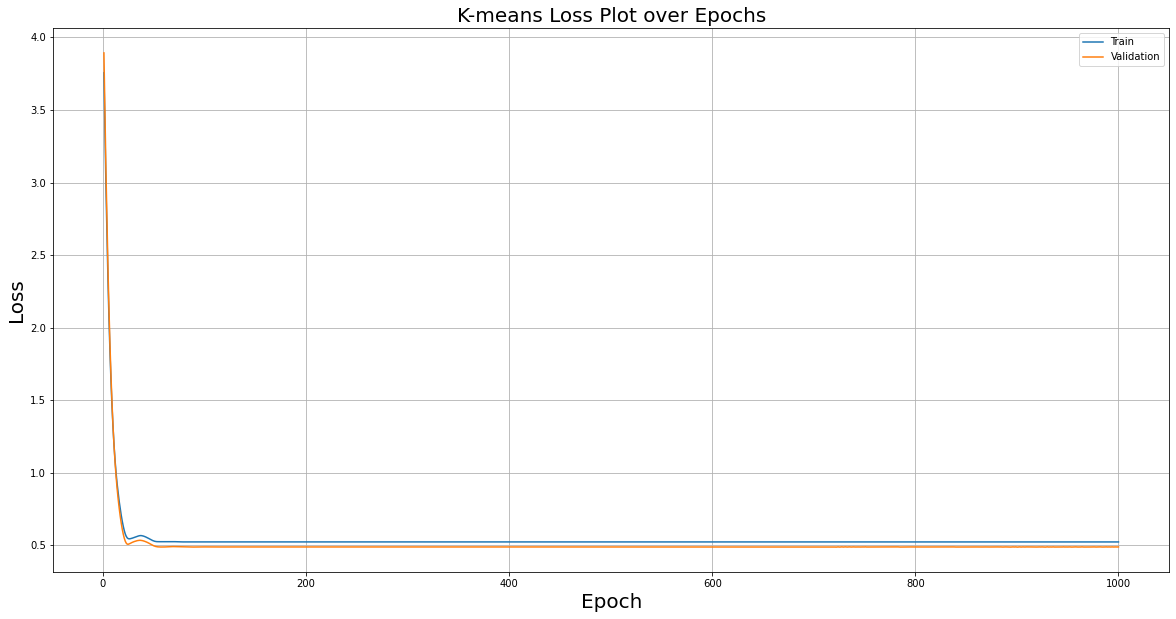

Final Training Loss: 0.5233652591705322
Final Validation Loss: 0.4890987277030945


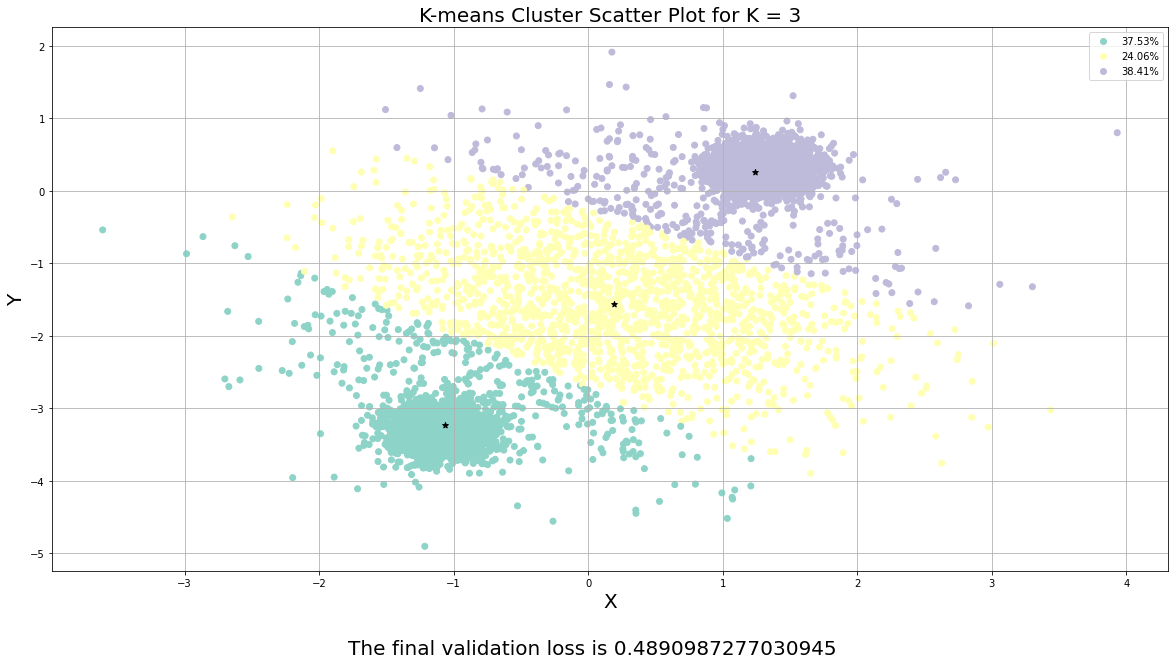




K = 4:


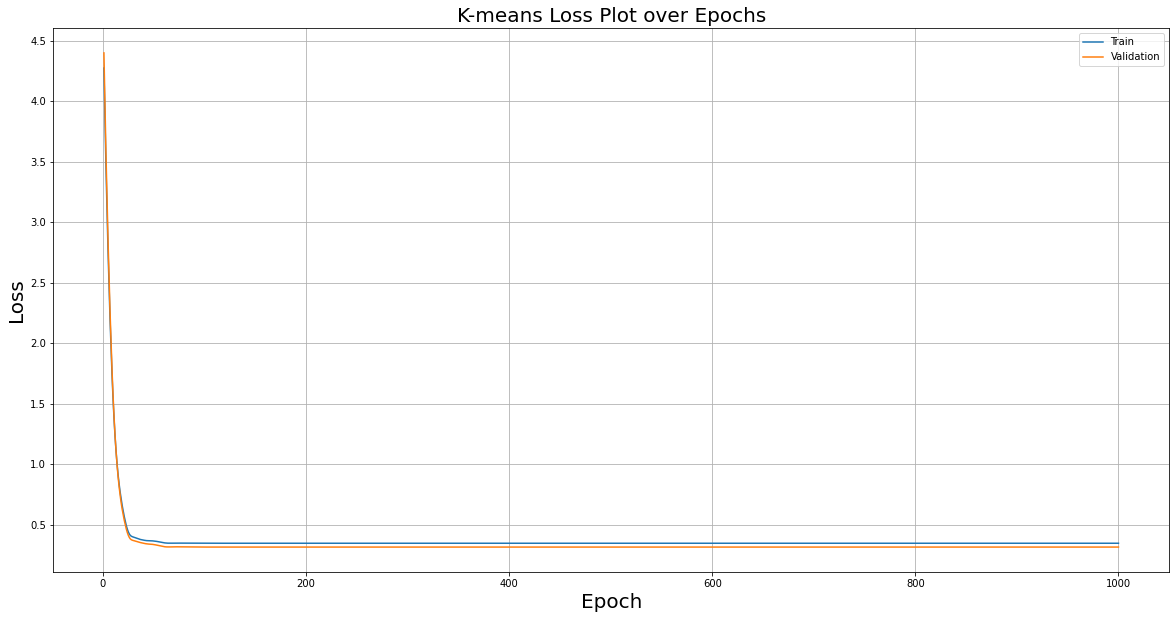

Final Training Loss: 0.34801867604255676
Final Validation Loss: 0.3164796531200409


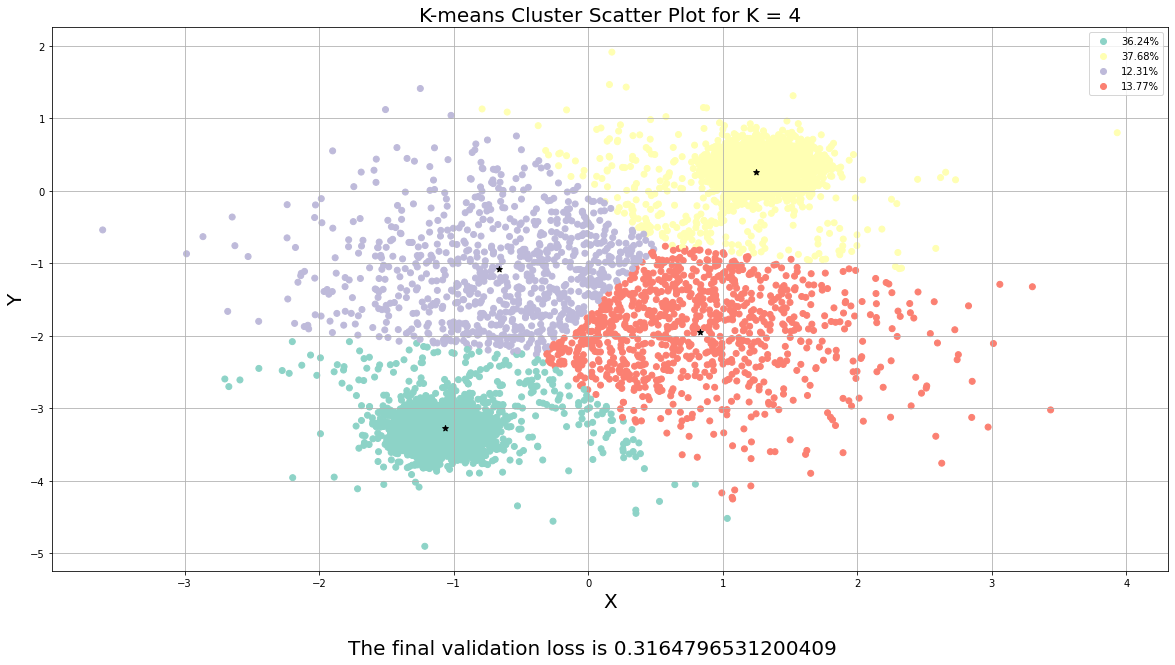




K = 5:


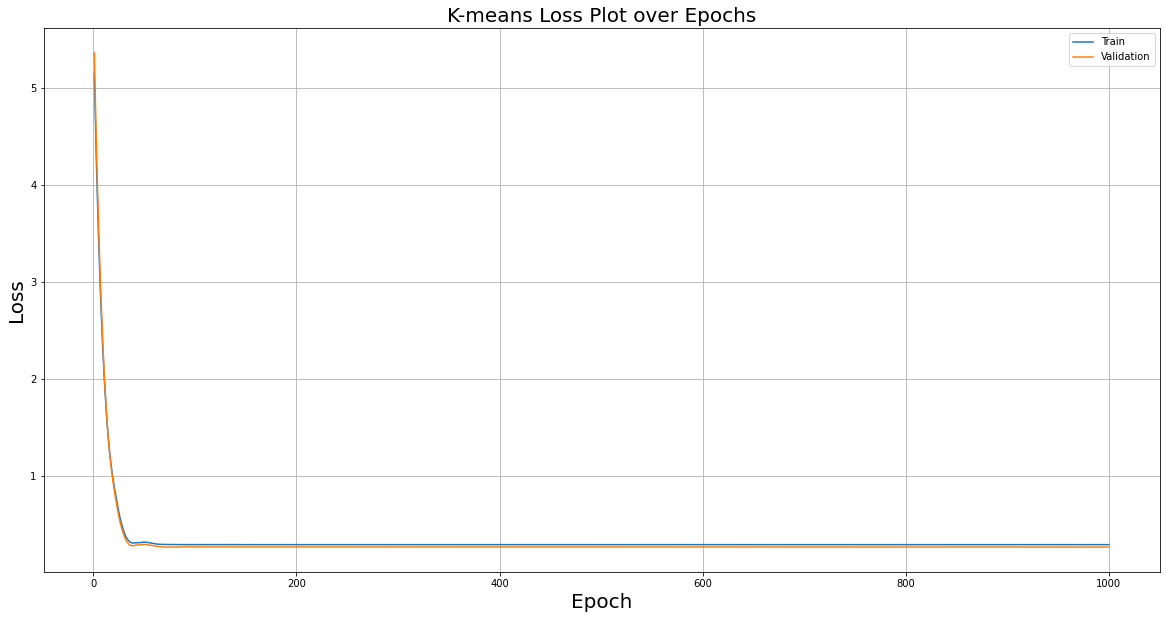

Final Training Loss: 0.29408901929855347
Final Validation Loss: 0.2690943479537964


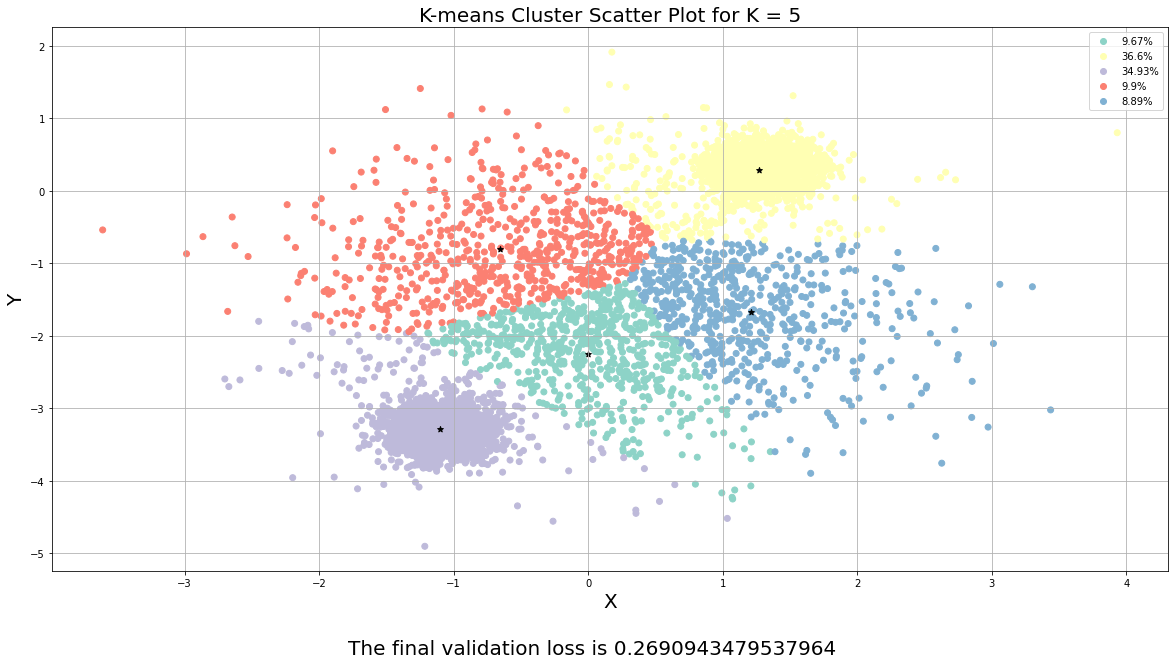

In [188]:
val_kmeans_1 = [None]*5
K_1 = [1,2,3,4,5]

for i in range(len(K_1)):
  print("K = {}:".format(K_1[i]))
  val_kmeans_1[i] = train_kmeans(K_1[i], path_data2D, 1000, True)
  print("\n\n")

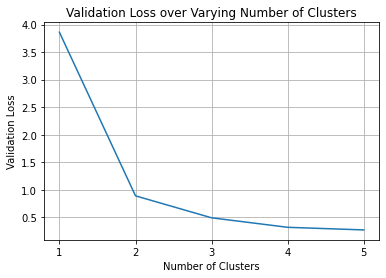

In [189]:
plt.plot(K_1, val_kmeans_1)
plt.xlabel("Number of Clusters")
plt.xticks(K_1)
plt.ylabel("Validation Loss")
plt.title("Validation Loss over Varying Number of Clusters")
plt.grid(True)

As the number of clusters approaches the number of number of datapoints, the loss will go to zero. Naively maximizing the number of clusters will result in overfitting. The validation loss' rate of change decreases drastically after 2 clusters. Furthermore, after 3 and 4 clusters, there is little change in the slope. Therefore, 3 or 4 clusters is the best choice.

# Part 2: Mixtures of Gaussians [16 points]

## Part 2.1: The Gaussian cluster mode [7 points]

### Part 2.1.1

A multivariate gaussian distribution is given by:

$\begin{aligned}
N(\boldsymbol{x}|\boldsymbol{\mu}^k, \sigma^{k^2})&=\frac{1}{\left(2\pi\right)^{\frac{d}{2}}|\Sigma|^{\frac{1}{2}}} \exp(-\frac{1}{2} (\boldsymbol{x} - \boldsymbol{\mu})^{T}\Sigma^{-1}(\boldsymbol{x} - \boldsymbol{\mu}))
\end{aligned}$ where $d$ is the number of variables

The different data dimensions are independent and have the same standard deviation, $\sigma^{k}$. Thus, the covariance is 0 and $\Sigma$ is a diagonal matrix where each element is $\sigma^{k^2}$. This simplifies the equation to:

$\begin{aligned}
N(\boldsymbol{x}|\boldsymbol{\mu}^k, \sigma^{k^2})&=\frac{1}{\left(2\pi\sigma^{k^2}\right)^{\frac{d}{2}}} \exp(-\frac{1}{2}\frac{|| \boldsymbol{x}-\boldsymbol{\mu} ||^2_2}{\sigma^{k^2}})
\end{aligned}$

Applying the logarithm:

$\begin{aligned}
\log(N(\boldsymbol{x}|\boldsymbol{\mu}^k, \sigma^{k^2}))&=\log(\frac{1}{\left(2\pi\sigma^{k^2}\right)^{\frac{d}{2}}} \exp(-\frac{1}{2}\frac{|| \boldsymbol{x}-\boldsymbol{\mu} ||^2_2}{\sigma^{k^2}})) \\
&= \log(\frac{1}{(2\pi\sigma^{k^2})^{\frac{d}{2}}}) - \frac{1}{2} \frac{|| \boldsymbol{x}-\boldsymbol{\mu} ||^2_2}{\sigma^{k^2}} \\
&= -\frac{d}{2}\log(2\pi\sigma^{k^2}) - \frac{1}{2} \frac{|| \boldsymbol{x}-\boldsymbol{\mu} ||^2_2}{\sigma^{k^2}} \\
&= -\frac{1}{2}(d\times\log(2\pi\sigma^{k^2}) + \frac{|| \boldsymbol{x}-\boldsymbol{\mu} ||^2_2}{\sigma^{k^2}})
\end{aligned}$

In [190]:
def log_GaussPDF(X, mu, sigma):
    # Inputs
    # X: N X D
    # mu: K X D
    # sigma: K X 1

    # Outputs:
    # log Gaussian PDF N X K

    term_log = -0.5 * X.shape[1] * tf.math.log(2*np.pi*sigma)
    term_dist = -0.5 * tf.transpose(tf.transpose(distanceFunc(X, mu))/sigma)
    log_PDF = tf.transpose(term_log) + term_dist

    return log_PDF

### Part 2.1.2

Using Baye's rule:

$\begin{aligned}
P(z=k|\textbf{x})&=\frac{P(\textbf{x}|z=k)P(z=k)}{P(\textbf{x})} \\
&=\frac{P(\textbf{x}|z=k)P(z=k)}{\sum_{i=1}^{K}P(\textbf{x}|z=i)P(z=i)}
\end{aligned}$

Using log rules:

$\begin{aligned}
\log(P(z=k|\textbf{x}))&=\log(\frac{P(\textbf{x}|z=k)P(z=k)}{P(\textbf{x})}) \\
&=\log(P(\textbf{x}|z=k)) + \log(P(z=k)) - \log(\sum_{i=1}^{K}P(\textbf{x}|z=i)P(z=i))
\end{aligned}$

Simplifying:

$\begin{aligned}
\log(P(z=k|\textbf{x}))&=\log(N(\textbf{x}|\mu^k, \sigma^{k^2})) + \log(\pi^k) - \log(\sum_{i=1}^{K} e^{\log(P(\textbf{x}|z=i)) + \log(P(z=i))})
\end{aligned}$

In [191]:
def log_posterior(log_PDF, log_pi):
    # Input
    # log_PDF: log Gaussian PDF N X K
    # log_pi: K X 1

    # Outputs
    # log_post: N X K

    log_pi = tf.transpose(log_pi)
    log_sum = reduce_logsumexp(log_PDF + log_pi, keep_dims=True)
    log_post = log_PDF + log_pi - log_sum

    return log_post

## Part 2.2: Learning the MoG [9 points]

### Part 2.2.1

$\begin{aligned}
L(\boldsymbol{\mu}, \sigma, \pi) &= -\log(P(\boldsymbol{X})) \\
&= - \log (\prod_{n=1}^{N} P(\boldsymbol{x}_n)) \\
&= - \sum_{n=1}^{N} \log(P(\boldsymbol{x}_n)) \\
&= - \sum_{n=1}^{N} \log(\sum_{i=1}^{K}P(\boldsymbol{x}_n|z=i)P(z=i)) \\
&= - \sum_{n=1}^{N} \log(\sum_{i=1}^{K} e^{\log(P(\boldsymbol{x}_n|z=i)) + \log(P(z=i))})
\end{aligned}$

In [192]:
def loss_MOG(data, MU, sigma, pi):
    log_PDF = log_GaussPDF(data, MU, tf.exp(sigma))
    log_pi =  tf.transpose(logsoftmax(pi))
    log_sum = reduce_logsumexp(log_PDF + log_pi, keep_dims=True)
    loss_mog = -1 * tf.math.reduce_sum(log_sum)
    
    return loss_mog/data.shape[0]

In [193]:
def plot_mog (train_loss, val_loss, data, MU, sigma, pi, plot_val):
    n = len(train_loss)

    fig = plt.figure(figsize=(20,10))
    plt.title("MoG Loss Plot over Epochs", fontsize=20)
    plt.plot(range(1,1+n), train_loss, label="Train")
    if plot_val:
        plt.plot(range(1,1+n), val_loss, label="Validation")
    plt.xlabel("Epoch", fontsize=20)
    plt.ylabel("Loss", fontsize=20)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    print("Final Training Loss: {}".format(train_loss[-1]))
    if plot_val:
        print("Final Validation Loss: {}".format(val_loss[-1]))

    fig = plt.figure(figsize=(20,10))
    plt.title("MoG Cluster Scatter Plot for K = {}".format(MU.shape[0]), fontsize=20)
    log_PDF = log_GaussPDF(data, MU, tf.exp(sigma))
    log_pi = logsoftmax(pi)
    log_post = log_posterior(log_PDF, log_pi)
    clusters = tf.argmax(tf.math.softmax(log_post), axis=1)
    N = clusters.shape[0]
    K = MU.shape[0]
    percents = [np.sum(np.equal(i, clusters)) * 100.0 / N for i in range(K)]
    scatter = plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap=ListedColormap(cm.get_cmap("Set3").colors[:K]),
                marker="o")
    plt.scatter(MU[:, 0], MU[:, 1], c="k", marker="*")
    plt.xlabel("X", fontsize=20)
    plt.ylabel("Y", fontsize=20)
    plt.legend(handles=scatter.legend_elements()[0], labels=[str(round(p, 2))+"%" for p in percents], loc="best")
    plt.grid(True)
    if plot_val:
        caption = "The final validation loss is {}".format(val_loss[-1])
        fig.text(0.5, 0.01, caption, ha='center', fontsize=20)
    plt.show()

In [194]:
def train_mog (K, data_path, epochs, train_val):
    train_data, val_data = loadData(data_path, train_val)
    train_loss, val_loss = [], []

    [num_pts, dims] = np.shape(train_data)

    MU = tf.Variable(tf.random.truncated_normal([K, dims], seed=45689), trainable=True)
    sigma = tf.Variable(tf.random.truncated_normal([K, 1], seed=45689), trainable=True)
    pi = tf.Variable(tf.random.truncated_normal([K, 1], seed=45689), trainable=True)

    optim = tf.keras.optimizers.Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.99, epsilon=1e-5)
    loss_fn = lambda: loss_MOG(train_data, MU, sigma, pi)

    for e in range(epochs):
        train_l = loss_MOG(train_data, MU, sigma, pi).numpy()
        train_loss.append(train_l)

        if train_val:
            val_l = loss_MOG(val_data, MU, sigma, pi).numpy()
            val_loss.append(val_l)

        optim.minimize(loss_fn, [MU, sigma, pi])

    plot_mog(train_loss, val_loss, train_data, MU, sigma, pi, train_val)

    if train_val:
        return train_loss, val_loss, MU, sigma, pi
    else:
        return train_loss, MU, sigma, pi

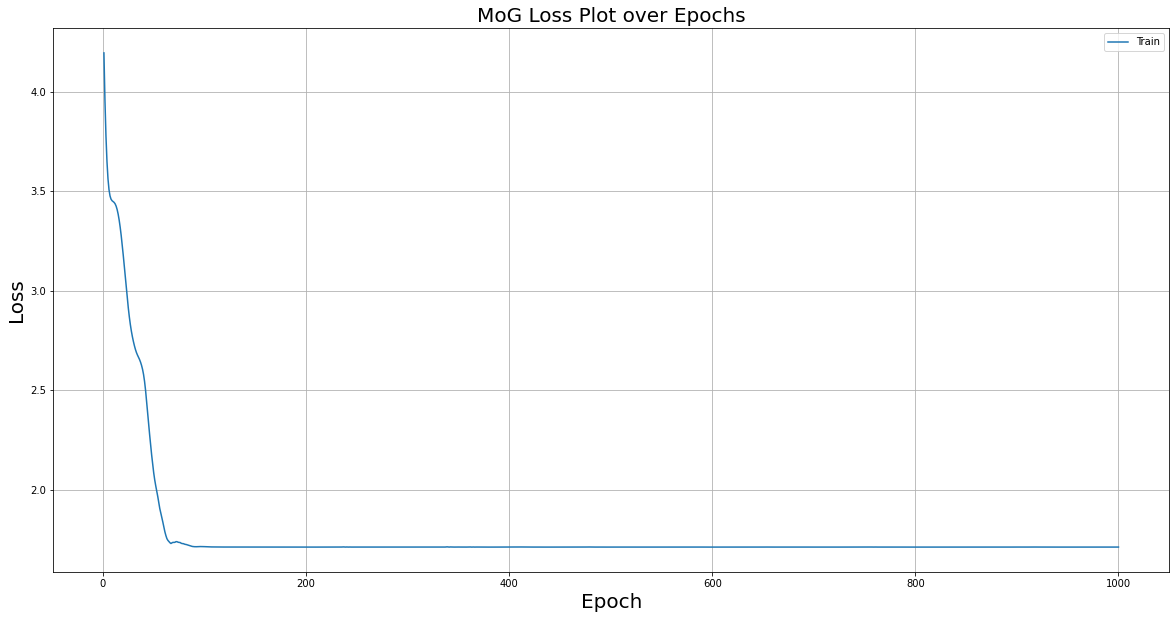

Final Training Loss: 1.7133538722991943


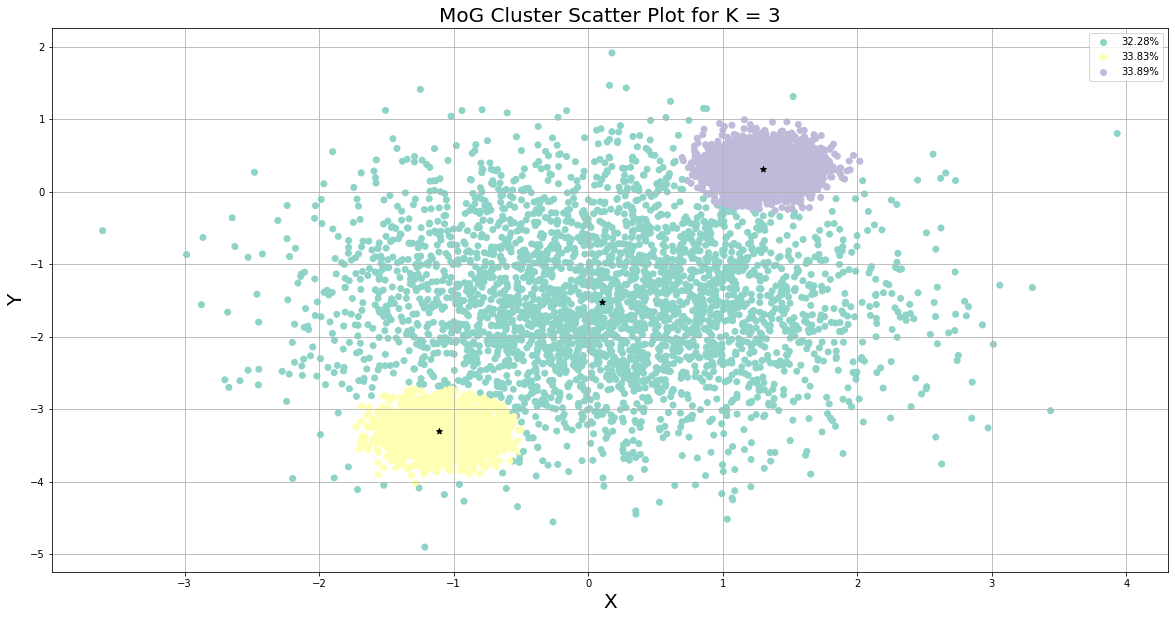

In [195]:
train_loss, MU, sigma, pi = train_mog(3, path_data2D, 1000, False)

In [196]:
for i in range(3):
  print("Cluster {}:\n\tmean:\t{}\n\tsigma:\t{}\n\tpi:\t{}\n".format(i+1, MU[i, :].numpy(), sigma[i].numpy(), pi[i].numpy()))

Cluster 1:
	mean:	[ 0.10233293 -1.5229275 ]
	sigma:	[-0.01308847]
	pi:	[-0.99727887]

Cluster 2:
	mean:	[-1.105643  -3.3048632]
	sigma:	[-3.2415414]
	pi:	[-1.0069609]

Cluster 3:
	mean:	[1.2985799  0.31104717]
	sigma:	[-3.2465427]
	pi:	[-0.99866825]



### Part 2.2.2

K = 1:


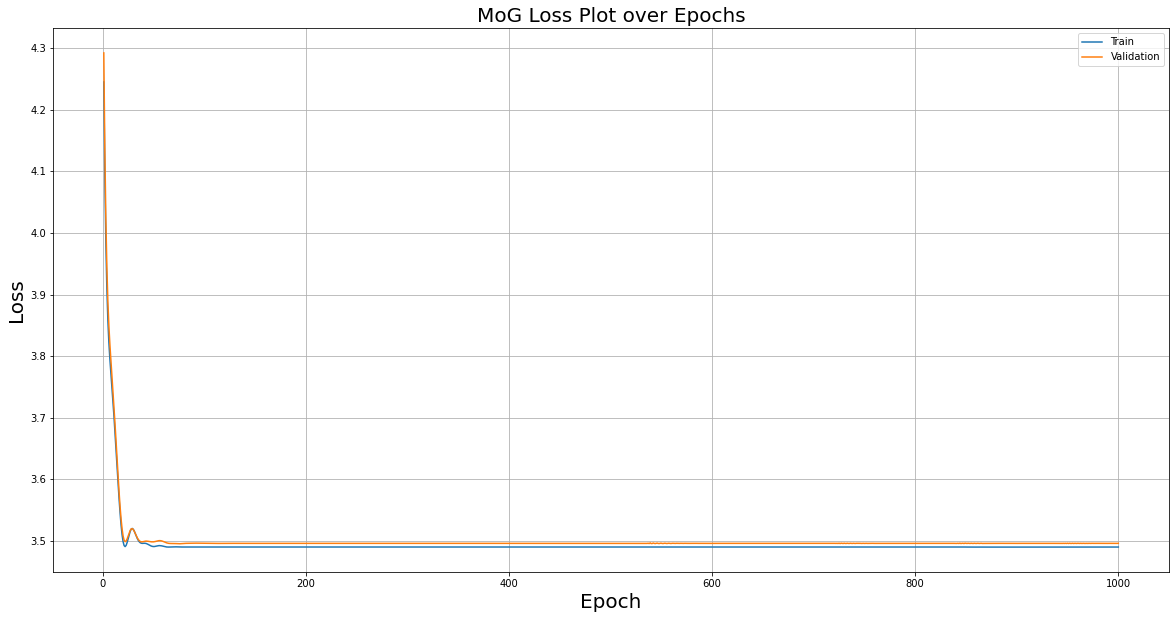

Final Training Loss: 3.489802360534668
Final Validation Loss: 3.4959542751312256


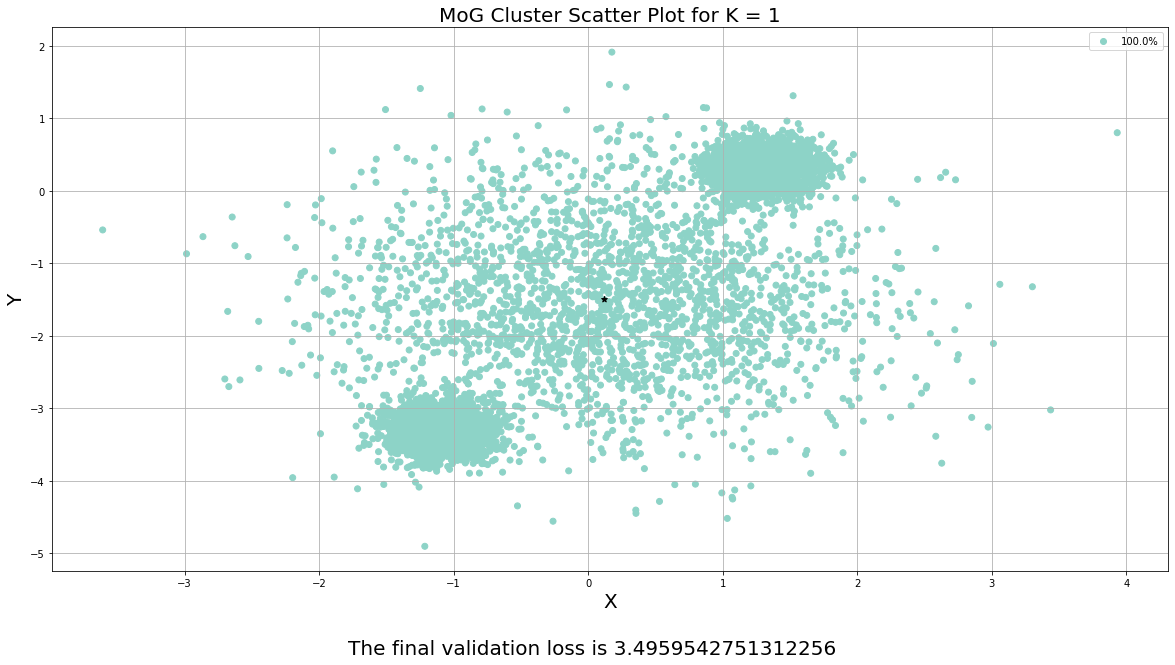




K = 2:


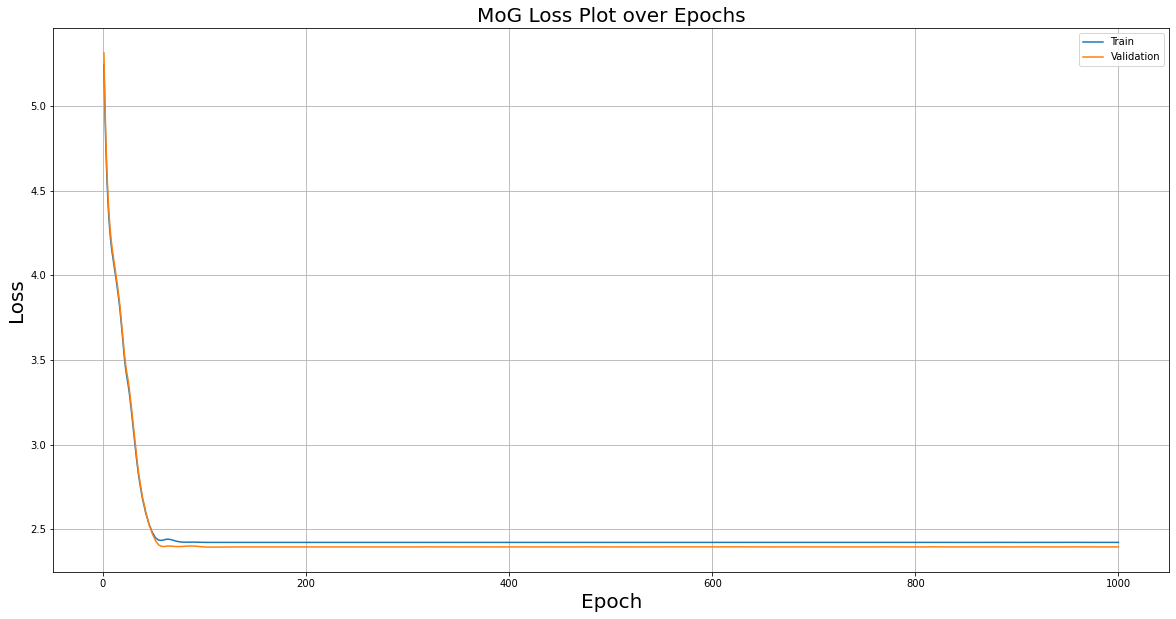

Final Training Loss: 2.423274517059326
Final Validation Loss: 2.3967175483703613


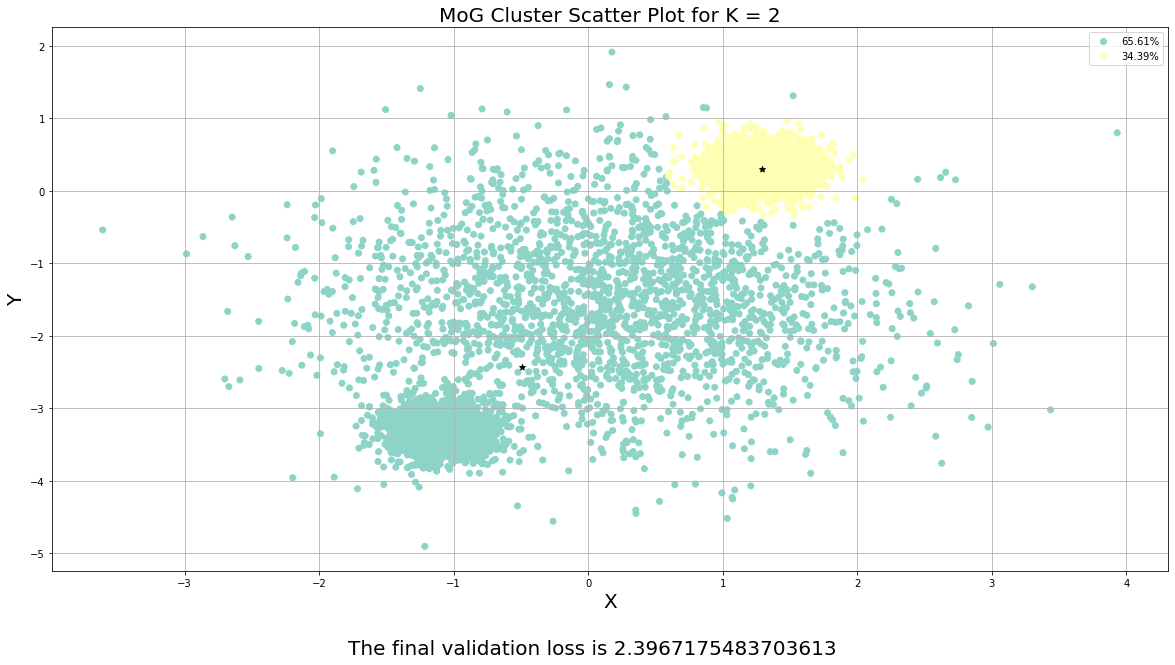




K = 3:


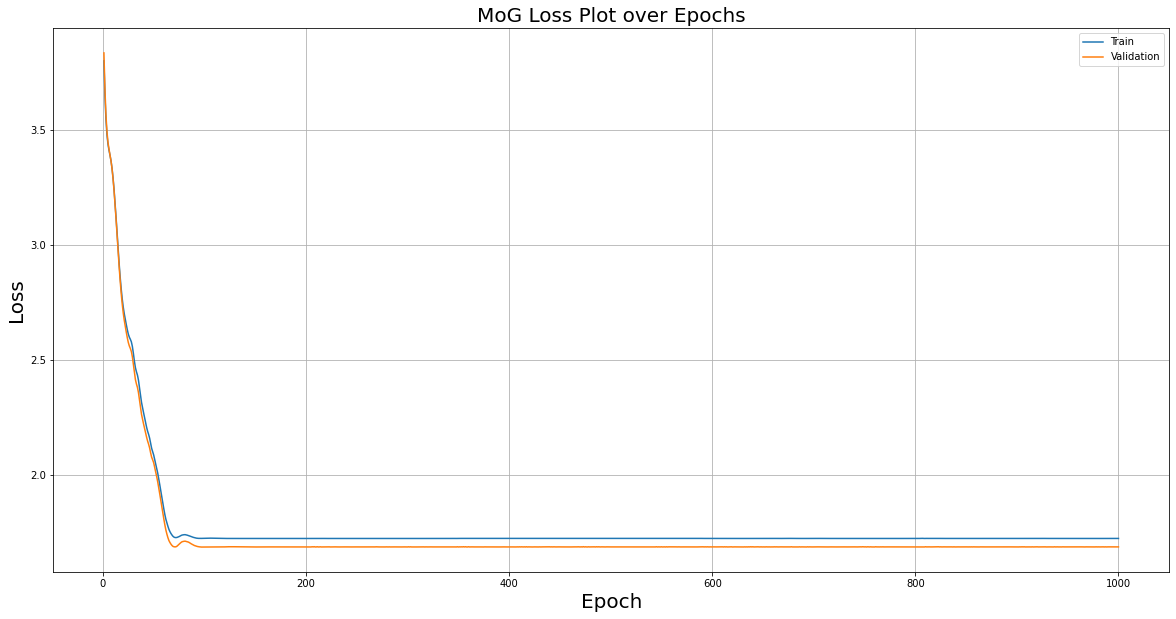

Final Training Loss: 1.726006031036377
Final Validation Loss: 1.6891913414001465


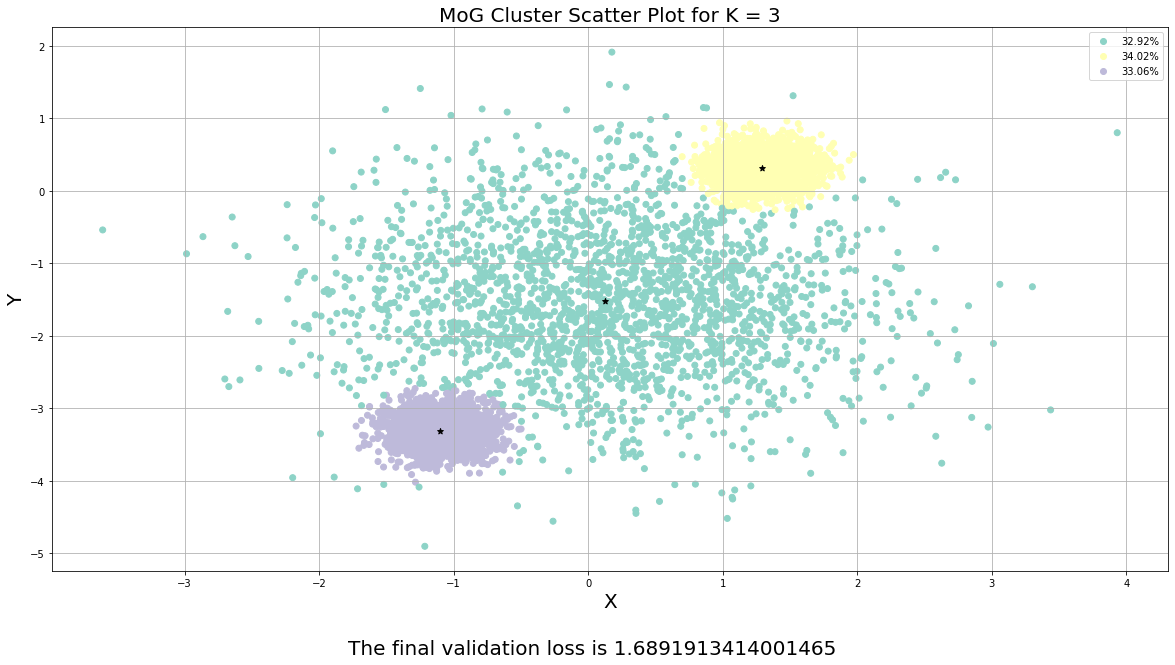




K = 4:


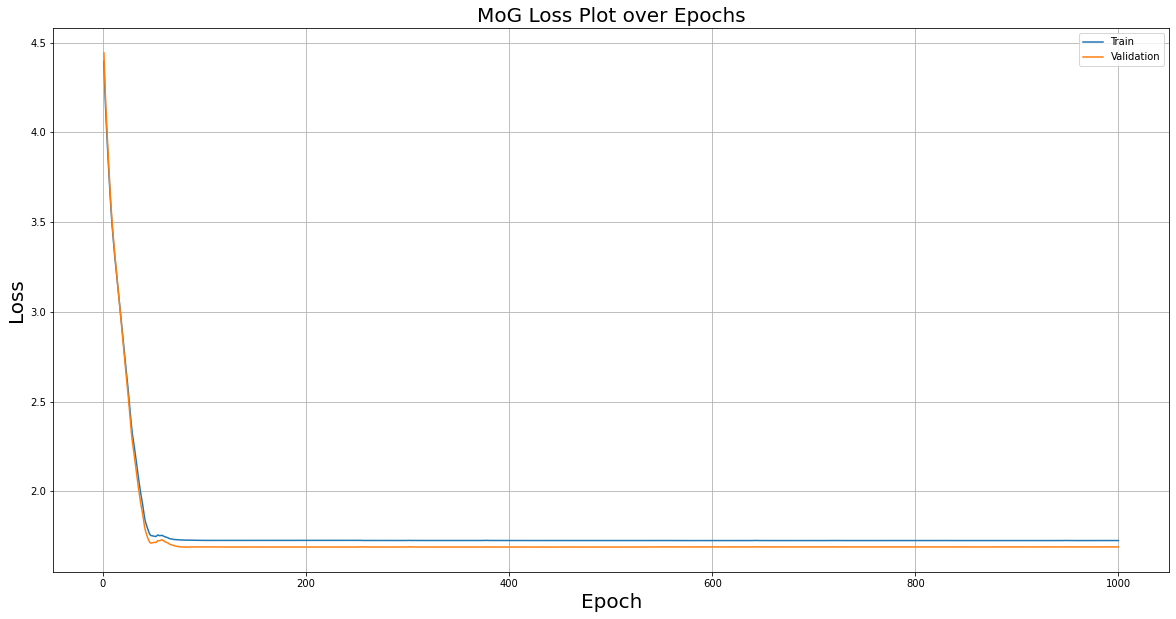

Final Training Loss: 1.7252463102340698
Final Validation Loss: 1.6898032426834106


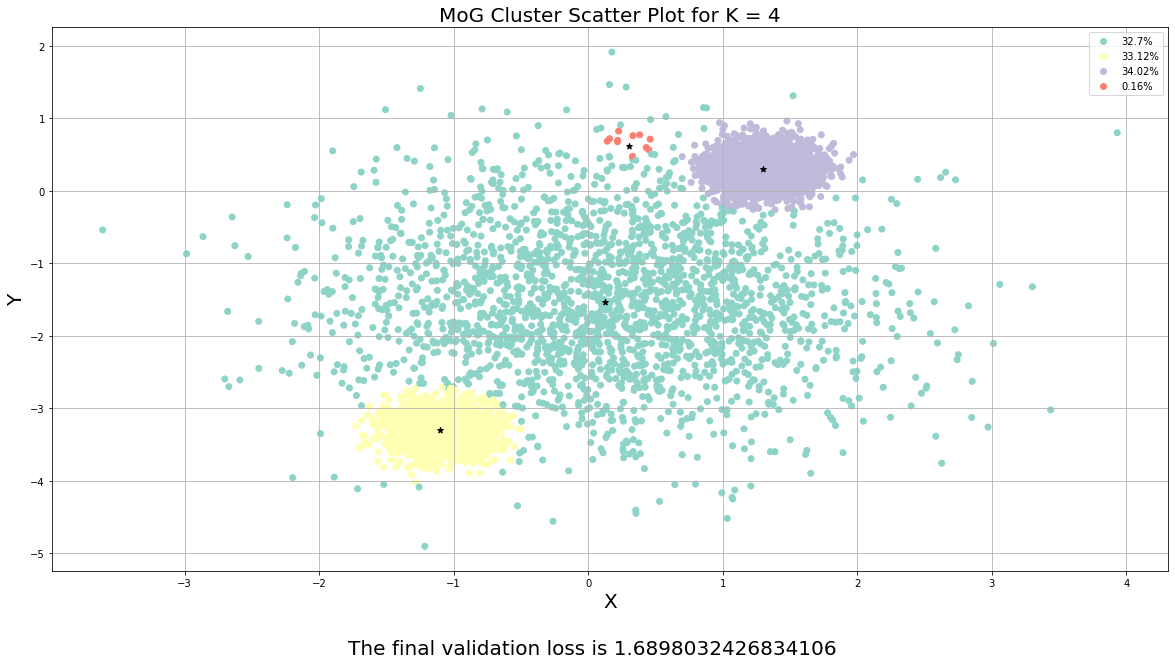




K = 5:


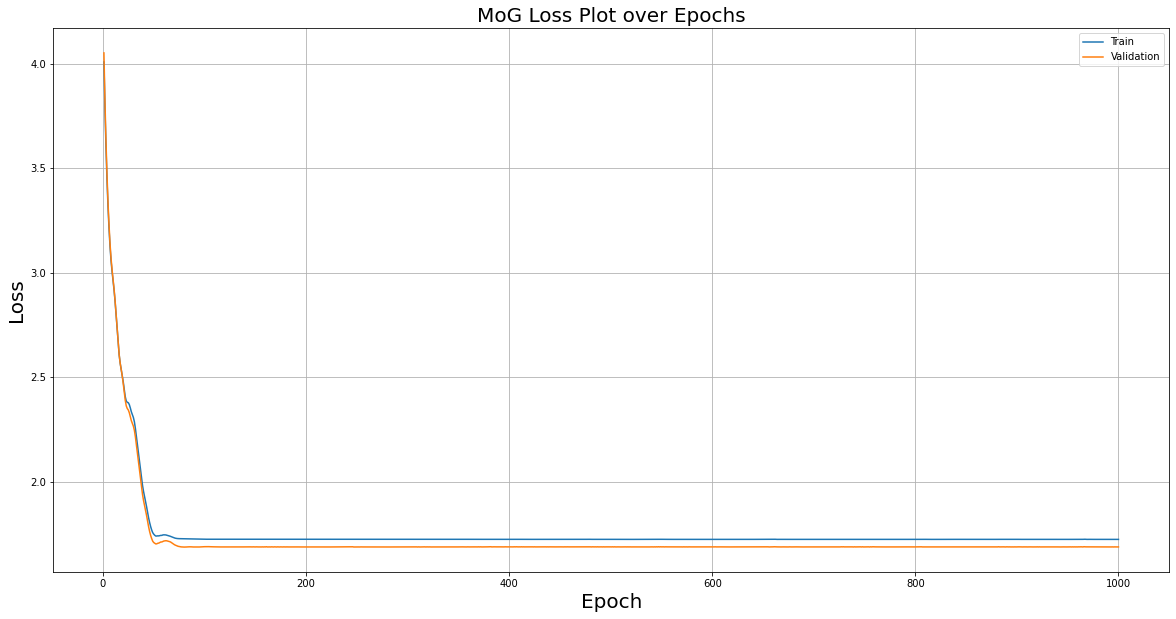

Final Training Loss: 1.725325107574463
Final Validation Loss: 1.689279556274414


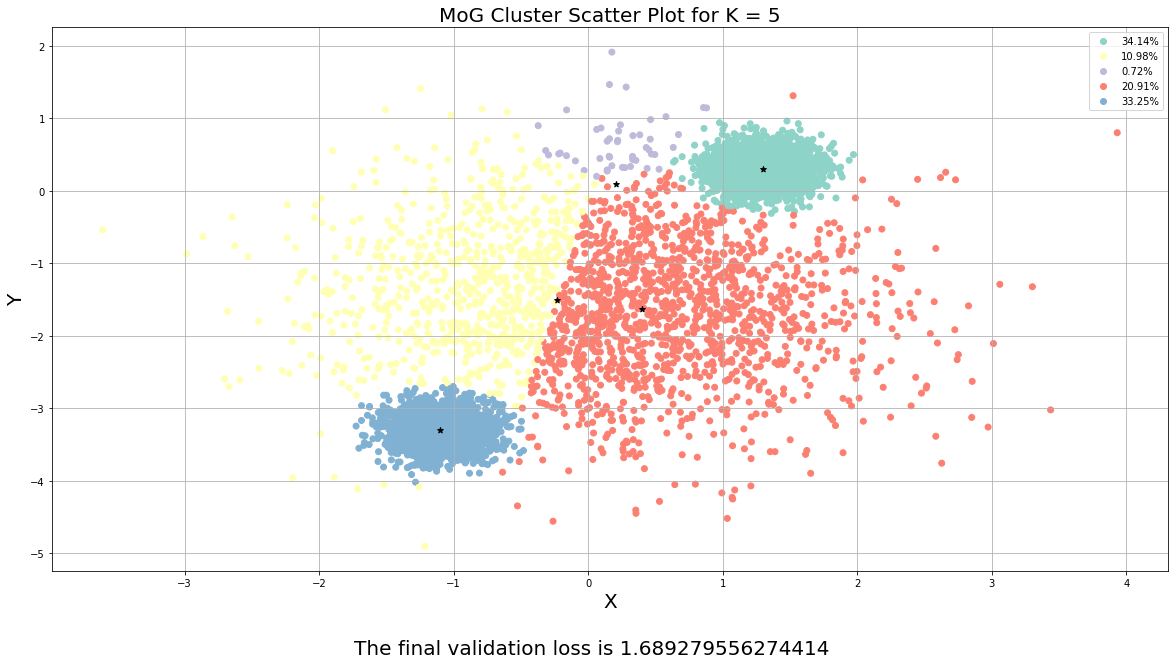

In [200]:
val_mog_1 = [None]*5
K_2 = [1,2,3,4,5]

for i in range(len(K_2)):
  print("K = {}:".format(K_2[i]))
  _, tmp, _, _, _ =  train_mog(K_2[i], path_data2D, 1000, True)
  val_mog_1[i] = tmp[-1]
  print("\n\n")

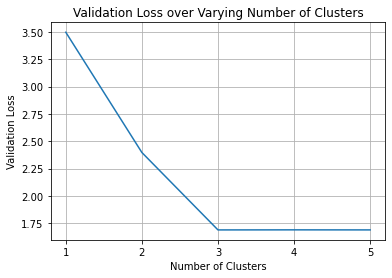

In [201]:
plt.plot(K_2, val_mog_1)
plt.xlabel("Number of Clusters")
plt.xticks(K_2)
plt.ylabel("Validation Loss")
plt.title("Validation Loss over Varying Number of Clusters")
plt.grid(True)

It is clearly evident that 3 clusters is the best choice as there is no improvement in the validation loss with 4 or more clusters. Furthermore, the scatter plots for 4 and 5 clusters look less ideal.

### Part 2.2.3

In [202]:
val_kmeans_2 = [None]*6
val_mog_2 = [None]*6
K_3 = [5,10,15,20,25,30]

for i in range(6):
  print("K = {}:".format(K_3[i]))
  val_kmeans_2[i] = train_kmeans(K_3[i], path_data100D, 200, True)
  print("\n")
  _, tmp, _, _, _ =  train_mog(K_3[i], path_data100D, 200, True)
  val_mog_2[i] = tmp[-1]
  print("\n\n")

Output hidden; open in https://colab.research.google.com to view.

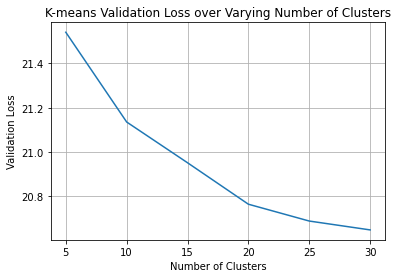

In [203]:
plt.plot(K_3, val_kmeans_2)
plt.xlabel("Number of Clusters")
plt.xticks(K_3)
plt.ylabel("Validation Loss")
plt.title("K-means Validation Loss over Varying Number of Clusters")
plt.grid(True)

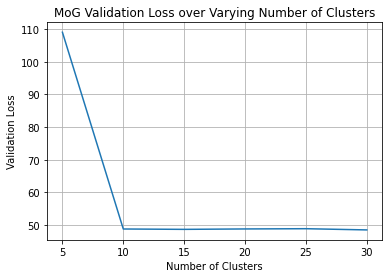

In [204]:
plt.plot(K_3, val_mog_2)
plt.xlabel("Number of Clusters")
plt.xticks(K_3)
plt.ylabel("Validation Loss")
plt.title("MoG Validation Loss over Varying Number of Clusters")
plt.grid(True)

The validation loss of the MoG model was minimized using 10 clusters. Increasing the number of clusters past this point caused no noticable improvement in the loss. On the other hand, the validation loss of the K-means model continued decreasing as the number of clusters increased. Thus, we can conclude that there are 10 clusters in the dataset.

Regarding the learnt results, the K-means model has a lower validation loss than the MoG model at each cluster size. This suggests that the K-means model is better at clustering the dataset.